SECOND ATTEMPT

This will look very familiar, so I'll just spend some time here reviewing the differences.  I changed the folder names where the images are stored so that I wouldn't overwrite the data I had already generated.  I also removed all forms of data augmentation in the data generation step, so that all I'm doing is saving the image, the matte, and generating the trimaps.  Because I'm shrinking each image to 100x100, the thickness of the trimap was much more important.  I started off using 2, then I changed that to 1 because both looked too thick.  Thickness of 1 looked way too thin, so I decided to experiment with both.

I was able to set the neural network (GluNet) to have both TNet and MNet together in one architecture.  This allowed for a much more cohesive training experience where the two networks learned together instead of one on top of the other.  I chose to train with the compositional loss as it worked the best from before.  I went with 400 epochs as the dataset was 15 times smaller (plus I'm training two networks so I figured I'd give it extra time to train).  As it turns out this was unecessary but I don't regret testing it out.

Finally, the ImageDataset class was given all of the image augmentations that I used before.  This means that each image gets 400 unique versions of itself, instead of the max being 20 from before.

In [1]:
import os
from os import path
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from scipy.io import loadmat
from skimage import io
import imutils
from tqdm import tqdm
import random

from PIL import Image,ImageOps


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision


CURRENT_DIR = path.abspath(path.curdir)
FOLDER = '/[EG_code_data]_release/data/'
IMG_SIZE = (100,100)

urls = pd.read_csv(CURRENT_DIR + FOLDER + 'alldata_urls.txt',names=['name','url'],delimiter=' ')
crops = pd.read_csv(CURRENT_DIR + FOLDER + 'crop.txt',names=['name','leftx','lefty','rightx','righty'],delimiter=' ')
trainlist = list(loadmat(CURRENT_DIR + FOLDER + 'trainlist')["trainlist"][0])
testlist = list(loadmat(CURRENT_DIR + FOLDER + 'testlist')["testlist"][0])

img_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.75)
    ,transforms.ToTensor()
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [2]:
for sample in tqdm(urls.T.iteritems()):
    
    try:
        og = io.imread(sample[1][1])
        crop = crops[crops['name']==sample[1][0]]
        og = og[crop['leftx'].values[0]:crop['lefty'].values[0],crop['rightx'].values[0]:crop['righty'].values[0],:]
        og = cv2.resize(og,IMG_SIZE)
        og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
        
        if int(sample[1][0].split('.')[0]) in testlist:
            traintest = 'test'

        elif int(sample[1][0].split('.')[0]) in trainlist:
            traintest = 'train'
            
        else:
            traintest = 'neither'
        
 
        

        # Grabbing the image and mask from the dataset
        image = og.copy()
        mask = np.asarray(loadmat(CURRENT_DIR + FOLDER + '/images_mask/' + sample[1][0].split('.')[0] + '_mask.mat')['mask'])
        mask = cv2.resize(mask,IMG_SIZE)
        

        inv_mask = cv2.bitwise_not(mask) - 254

        data = image.copy()

        # Saving the results to a file
        
        ret, thresh = cv2.threshold(mask,127,255,0)
        contours,hierarchy = cv2.findContours(mask, 1, 2)
        trimap = cv2.drawContours(np.zeros((IMG_SIZE[1],IMG_SIZE[0])), contours, -1,(255),thickness=-1)

        trimap = cv2.drawContours(trimap,contours,-1,(127),thickness=2)
        kernel = np.ones((5,5),np.uint8)
        trimap = cv2.erode(trimap,kernel,iterations=3)
        trimap = cv2.dilate(trimap,kernel,iterations=3)
        

        
        background_channel = np.where(trimap==0,float(1),0)
        uncertain_channel = np.where(trimap==127,float(1),0)
        foreground_channel = np.where(trimap==255,float(1),0)
        trimap = cv2.merge((background_channel,uncertain_channel,foreground_channel))

        cv2.imwrite(os.path.join(CURRENT_DIR,'data2',traintest,'data_' + sample[1][0].split('.')[0] + '.png'),data)
        cv2.imwrite(os.path.join(CURRENT_DIR,'matte2',traintest,'matte_' + sample[1][0].split('.')[0] + '.png'),mask)
        cv2.imwrite(os.path.join(CURRENT_DIR,'trimap2',traintest,'trimap_' + sample[1][0].split('.')[0] + '.png'),trimap)


    except Exception as e:

#         print(e)
        pass

    

print(len(os.listdir(CURRENT_DIR + '/data2/train/')) + len(os.listdir(CURRENT_DIR + '/data2/test/'))) 

1879it [08:24,  3.73it/s]

1494


In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat((x1,x2),1)
        x = self.conv(x)
        return x
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class GluNet(nn.Module):
    def __init__(self, bilinear=True):
        super(GluNet, self).__init__()
        self.bilinear = bilinear

        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256,64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64,3)
        
        self.inc1 = DoubleConv(6, 64)
        self.down1_1 = Down(64, 128)
        self.down2_1 = Down(128, 256)
        self.down3_1 = Down(256,512)
        self.down4_1 = Down(512,512)
        self.up1_1 = Up(1024, 256, bilinear)
        self.up2_1 = Up(512, 128, bilinear)
        self.up3_1 = Up(256,64, bilinear)
        self.up4_1 = Up(128, 64, bilinear)
        self.outc1 = OutConv(64,1)
        


    def forward(self, image):
        
        
        
        x1 = self.inc(image)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x4,x5)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        
        trimap = F.softmax(self.outc(x),dim=1)
        x = torch.cat((image,trimap),1)


        x1 = self.inc1(x)
        x2 = self.down1_1(x1)
        x3 = self.down2_1(x2)
        x4 = self.down3_1(x3)
        x5 = self.down4_1(x4)
        x = self.up1_1(x4,x5)
        x = self.up2_1(x,x3)
        x = self.up3_1(x,x2)
        x = self.up4_1(x,x1)

        matte = torch.sigmoid(self.outc1(x))

        return trimap, matte

In [3]:
class ImageDataset(Dataset):

    def __init__(self,test=False,transform=None):
        self.root = path.abspath(path.curdir)
        self.transform = transform
        self.traintest = 'test' if test else 'train'
        self.data = os.listdir(self.root + f'/data2/{self.traintest}/')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):

        if torch.is_tensor(index):
            index = index.tolist()

        item = Image.open(self.root + f'/data2/{self.traintest}/' + self.data[index])
        trimap = Image.open(self.root + f'/trimap2/{self.traintest}/' + self.data[index].replace("data","trimap"))
        matte = Image.open(self.root + f'/matte2/{self.traintest}/' + self.data[index].replace("data","matte"))
        
        
        flip = np.random.randint(0,2)
        
        if flip>0:
            
            item = ImageOps.mirror(item)
            trimap = ImageOps.mirror(trimap)
            matte = ImageOps.mirror(matte)
        
        rotation = np.random.randint(-30,31)
        item = item.rotate(rotation)
        trimap = trimap.rotate(rotation)
        matte = matte.rotate(rotation)
        
        x1, y1, x2, y2 = np.random.randint(0,26), np.random.randint(0,26), 100 - np.random.randint(0,26), 100-np.random.randint(0,26)
        
        item = item.crop((x1,y1,x2,y2))
        trimap = trimap.crop((x1,y1,x2,y2))
        matte = matte.crop((x1,y1,x2,y2))
        
        item = item.resize((100,100))
        trimap = trimap.resize((100,100))
        matte = matte.resize((100,100))
        
        
        if self.transform:
            item = self.transform(item)
            trimap = transforms.ToTensor()(trimap)*255
            matte = transforms.ToTensor()(matte)*255

        
        return item, trimap, matte

In [4]:
trainset = ImageDataset(transform=img_transform)

trainloader = DataLoader(
    trainset,
    batch_size=16,
    shuffle=True
    )

In [5]:
class CompositionalLoss(nn.Module):
    
    
    def __init__(self) -> None:
        super(CompositionalLoss, self).__init__()
        self.epsilon: float = 1e-6
        
    def forward(self,output,target):
        
       
        loss = torch.pow(torch.pow(output - target,2) + self.epsilon,0.5)
        
        return torch.mean(loss)

In [6]:
EPOCHS = 400
LR = 0.001
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CURRENT_DIR = path.abspath(path.curdir)

GNet = GluNet()
GNet.to(DEVICE)
optimizer = optim.Adam(GNet.parameters(),lr=LR)
loss_function1 = CompositionalLoss()
loss_function2 = CompositionalLoss()

In [7]:
def train(net,trainloader):
    
    loss_tracker = []
    
    for epoch in range(EPOCHS):
        
        avg_loss = 0
        
        for data in tqdm(trainloader): 
            
            net.zero_grad()
            
            images, trimaps, mattes = data[0].float().to(DEVICE), data[1].float().to(DEVICE), data[2].float().to(DEVICE)


            outputs1, outputs2 = net(images)
            loss = loss_function1(outputs1,trimaps) + loss_function2(outputs2,mattes)
            loss.backward()
            optimizer.step()
            
            images.cpu()
            trimaps.cpu()
            mattes.cpu()

            avg_loss += loss
            
        avg_loss /= 20592    

        print(f"Epoch: {epoch+1}. Avg Loss: {avg_loss}.")
        
        loss_tracker.append(avg_loss)
        
        torch.save(GNet.state_dict(),CURRENT_DIR + f'/Models/GNET COMP v{epoch+1}')
        
    return loss_tracker

In [8]:
losses = train(GNet,trainloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:34<00:00,  1.21s/it]


Epoch: 1. Avg Loss: 0.0019288234179839492.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 2. Avg Loss: 0.0013784022303298116.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 3. Avg Loss: 0.0012831087224185467.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 4. Avg Loss: 0.0011967293685302138.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 5. Avg Loss: 0.001141696935519576.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 6. Avg Loss: 0.001102045294828713.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 7. Avg Loss: 0.0011229695519432425.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 8. Avg Loss: 0.0010548343416303396.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 9. Avg Loss: 0.0010405204957351089.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 10. Avg Loss: 0.0010319355642423034.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 11. Avg Loss: 0.0010771480156108737.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.72it/s]


Epoch: 12. Avg Loss: 0.0010043244110420346.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 13. Avg Loss: 0.0009906318737193942.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 14. Avg Loss: 0.0009305719286203384.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 15. Avg Loss: 0.0009292833274230361.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 16. Avg Loss: 0.0009210603893734515.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 17. Avg Loss: 0.0008936474332585931.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 18. Avg Loss: 0.0009015261312015355.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 19. Avg Loss: 0.0008694389252923429.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 20. Avg Loss: 0.0009053382673300803.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 21. Avg Loss: 0.0008328245603479445.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 22. Avg Loss: 0.0008476204238831997.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 23. Avg Loss: 0.0008209560764953494.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 24. Avg Loss: 0.0008194527472369373.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 25. Avg Loss: 0.0008303760550916195.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 26. Avg Loss: 0.0008693845593370497.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 27. Avg Loss: 0.0008185803890228271.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 28. Avg Loss: 0.0007907924591563642.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 29. Avg Loss: 0.0007525637047365308.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 30. Avg Loss: 0.0007379775634035468.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 31. Avg Loss: 0.0007274832460097969.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 32. Avg Loss: 0.0007301804726012051.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 33. Avg Loss: 0.0007094907341524959.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 34. Avg Loss: 0.0007050159620121121.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 35. Avg Loss: 0.0007096818881109357.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 36. Avg Loss: 0.0007097090710885823.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 37. Avg Loss: 0.0006649423739872873.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 38. Avg Loss: 0.0006569824763573706.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 39. Avg Loss: 0.000655262207146734.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch: 40. Avg Loss: 0.0006245223921723664.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 41. Avg Loss: 0.0006215408793650568.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 42. Avg Loss: 0.0006099122692830861.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 43. Avg Loss: 0.0006008168566040695.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 44. Avg Loss: 0.000613433017861098.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 45. Avg Loss: 0.0006120353937149048.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 46. Avg Loss: 0.0006003370508551598.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 47. Avg Loss: 0.0005589788779616356.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 48. Avg Loss: 0.0005955988308414817.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 49. Avg Loss: 0.0005805666442029178.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 50. Avg Loss: 0.0005691862897947431.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 51. Avg Loss: 0.0005572133231908083.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 52. Avg Loss: 0.0005533792427740991.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 53. Avg Loss: 0.0005723587237298489.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 54. Avg Loss: 0.0005543312872759998.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 55. Avg Loss: 0.0005292912246659398.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 56. Avg Loss: 0.000546850438695401.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 57. Avg Loss: 0.0005284721264615655.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.68it/s]


Epoch: 58. Avg Loss: 0.0005379230133257806.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 59. Avg Loss: 0.000524930190294981.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 60. Avg Loss: 0.0005621419986709952.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 61. Avg Loss: 0.0005423628026619554.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 62. Avg Loss: 0.0005410521407611668.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 63. Avg Loss: 0.0005164463655091822.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 64. Avg Loss: 0.000523426802828908.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 65. Avg Loss: 0.000533878046553582.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 66. Avg Loss: 0.0005017084768041968.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 67. Avg Loss: 0.0005117812543176115.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 68. Avg Loss: 0.0005205186316743493.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 69. Avg Loss: 0.00050083186943084.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 70. Avg Loss: 0.00048219255404546857.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 71. Avg Loss: 0.0004939470090903342.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 72. Avg Loss: 0.000497823057230562.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 73. Avg Loss: 0.0005004447302781045.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 74. Avg Loss: 0.0004730460059363395.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 75. Avg Loss: 0.00046940354513935745.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 76. Avg Loss: 0.0005000323872081935.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 77. Avg Loss: 0.0004679643316194415.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 78. Avg Loss: 0.0004692180664278567.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 79. Avg Loss: 0.0004705915634986013.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 80. Avg Loss: 0.000447364232968539.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 81. Avg Loss: 0.00046203818055801094.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 82. Avg Loss: 0.00045265996595844626.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 83. Avg Loss: 0.00046448715147562325.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 84. Avg Loss: 0.0004752142704091966.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 85. Avg Loss: 0.0005004415288567543.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 86. Avg Loss: 0.0004775291890837252.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 87. Avg Loss: 0.00047692289808765054.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 88. Avg Loss: 0.0004482911608647555.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 89. Avg Loss: 0.00045580632286146283.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 90. Avg Loss: 0.00044993101619184017.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 91. Avg Loss: 0.0004315418191254139.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 92. Avg Loss: 0.0004485821700654924.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 93. Avg Loss: 0.0004359965387266129.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 94. Avg Loss: 0.000446739315520972.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 95. Avg Loss: 0.0004445404920261353.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 96. Avg Loss: 0.00044472308945842087.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 97. Avg Loss: 0.0004526608972810209.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 98. Avg Loss: 0.0004662532883230597.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 99. Avg Loss: 0.0004225415177643299.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 100. Avg Loss: 0.00048814728506840765.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 101. Avg Loss: 0.0004359876911621541.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 102. Avg Loss: 0.0004245867603458464.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 103. Avg Loss: 0.00042951334035024047.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 104. Avg Loss: 0.00042283619404770434.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 105. Avg Loss: 0.0004402780905365944.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 106. Avg Loss: 0.0004340994346421212.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 107. Avg Loss: 0.000414411595556885.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 108. Avg Loss: 0.00043280053068883717.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 109. Avg Loss: 0.000440176110714674.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 110. Avg Loss: 0.00041780207538977265.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 111. Avg Loss: 0.00041166413575410843.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 112. Avg Loss: 0.0004149033047724515.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 113. Avg Loss: 0.00041624638834036887.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch: 114. Avg Loss: 0.00043391570216044784.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 115. Avg Loss: 0.0003964418428950012.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 116. Avg Loss: 0.0004024882218800485.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 117. Avg Loss: 0.0004167688312008977.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 118. Avg Loss: 0.00040832816739566624.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 119. Avg Loss: 0.0003985125804319978.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 120. Avg Loss: 0.00041091424645856023.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 121. Avg Loss: 0.00039299941272474825.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 122. Avg Loss: 0.00038724931073375046.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 123. Avg Loss: 0.00041379561298526824.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 124. Avg Loss: 0.00040791218634694815.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 125. Avg Loss: 0.00039850949542596936.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 126. Avg Loss: 0.00040961382910609245.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 127. Avg Loss: 0.0004195645160507411.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 128. Avg Loss: 0.00039042512071318924.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 129. Avg Loss: 0.0004340423329267651.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 130. Avg Loss: 0.00040784134762361646.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 131. Avg Loss: 0.0003891626838594675.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 132. Avg Loss: 0.00038504181429743767.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 133. Avg Loss: 0.00037927256198599935.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 134. Avg Loss: 0.00039265453233383596.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 135. Avg Loss: 0.000385640247259289.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 136. Avg Loss: 0.00037227090797387064.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 137. Avg Loss: 0.0003774456854443997.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 138. Avg Loss: 0.0003815669915638864.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch: 139. Avg Loss: 0.0003699475491885096.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 140. Avg Loss: 0.0003801732091233134.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 141. Avg Loss: 0.00038026945549063385.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 142. Avg Loss: 0.0003769696631934494.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 143. Avg Loss: 0.0003716132487170398.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 144. Avg Loss: 0.00038257770938798785.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 145. Avg Loss: 0.000408733932999894.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 146. Avg Loss: 0.00038098081131465733.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 147. Avg Loss: 0.0003691118909046054.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 148. Avg Loss: 0.0003654086322057992.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 149. Avg Loss: 0.00038033933378756046.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 150. Avg Loss: 0.00036118848947808146.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 151. Avg Loss: 0.00036088592605665326.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 152. Avg Loss: 0.0003743323322851211.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 153. Avg Loss: 0.000365104409866035.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 154. Avg Loss: 0.00036318149068392813.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 155. Avg Loss: 0.0003788847825489938.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 156. Avg Loss: 0.0003642798983491957.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 157. Avg Loss: 0.0003472965909168124.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 158. Avg Loss: 0.0003667205455712974.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 159. Avg Loss: 0.000403613259550184.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 160. Avg Loss: 0.0003774664655793458.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 161. Avg Loss: 0.00036438662209548056.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 162. Avg Loss: 0.000361952610546723.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 163. Avg Loss: 0.0003743461857084185.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 164. Avg Loss: 0.0003931573301088065.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 165. Avg Loss: 0.0003668761346489191.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 166. Avg Loss: 0.00036316656041890383.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 167. Avg Loss: 0.00035231452784501016.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 168. Avg Loss: 0.0003548938548192382.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 169. Avg Loss: 0.00037250437890179455.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 170. Avg Loss: 0.00036049963091500103.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 171. Avg Loss: 0.00035995987127535045.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 172. Avg Loss: 0.0003587945830076933.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 173. Avg Loss: 0.00034886595676653087.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 174. Avg Loss: 0.0003637378686107695.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 175. Avg Loss: 0.00034114462323486805.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 176. Avg Loss: 0.0003523988416418433.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 177. Avg Loss: 0.0003361575654707849.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 178. Avg Loss: 0.0003351584600750357.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 179. Avg Loss: 0.00033682421781122684.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 180. Avg Loss: 0.0003492508258204907.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 181. Avg Loss: 0.00034960705670528114.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 182. Avg Loss: 0.0003397817490622401.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 183. Avg Loss: 0.00034878289443440735.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 184. Avg Loss: 0.00034718369715847075.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 185. Avg Loss: 0.0003533781855367124.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 186. Avg Loss: 0.0003486314381007105.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 187. Avg Loss: 0.0003490499220788479.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 188. Avg Loss: 0.00032712778192944825.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 189. Avg Loss: 0.00034466717625036836.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 190. Avg Loss: 0.0003360214759595692.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 191. Avg Loss: 0.00034119896008633077.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 192. Avg Loss: 0.00035641694557853043.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 193. Avg Loss: 0.0003437961859162897.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 194. Avg Loss: 0.00033694642479531467.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 195. Avg Loss: 0.00034476196742616594.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 196. Avg Loss: 0.00033304913085885346.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 197. Avg Loss: 0.00031831939122639596.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 198. Avg Loss: 0.00033070184872485697.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 199. Avg Loss: 0.0003572232380975038.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 200. Avg Loss: 0.0003450500953476876.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 201. Avg Loss: 0.000346583517966792.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 202. Avg Loss: 0.0003178041661158204.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 203. Avg Loss: 0.0003266562125645578.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 204. Avg Loss: 0.0003140128974337131.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 205. Avg Loss: 0.0003459625586401671.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 206. Avg Loss: 0.0003208686539437622.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 207. Avg Loss: 0.000336368044372648.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 208. Avg Loss: 0.00033297689515165985.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 209. Avg Loss: 0.0003253793984185904.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 210. Avg Loss: 0.0003246091364417225.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 211. Avg Loss: 0.00032814202131703496.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 212. Avg Loss: 0.0003315512149129063.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:54<00:00,  1.44it/s]


Epoch: 213. Avg Loss: 0.00032574008218944073.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 214. Avg Loss: 0.0003281440876889974.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 215. Avg Loss: 0.0003192900330759585.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 216. Avg Loss: 0.0003267094143666327.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 217. Avg Loss: 0.0003149337717331946.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 218. Avg Loss: 0.00030710885766893625.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 219. Avg Loss: 0.0003209488932043314.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 220. Avg Loss: 0.00032607559114694595.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 221. Avg Loss: 0.00032222268055193126.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 222. Avg Loss: 0.0003183751832693815.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 223. Avg Loss: 0.00030928818159736693.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 224. Avg Loss: 0.00034367298940196633.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 225. Avg Loss: 0.0003400213026907295.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 226. Avg Loss: 0.0003210979048162699.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 227. Avg Loss: 0.0003214245953131467.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 228. Avg Loss: 0.00031691743060946465.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 229. Avg Loss: 0.0003238542121835053.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 230. Avg Loss: 0.0003151732380501926.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 231. Avg Loss: 0.00032273950637318194.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 232. Avg Loss: 0.0003247607673984021.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 233. Avg Loss: 0.0003202179213985801.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 234. Avg Loss: 0.00031347956974059343.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 235. Avg Loss: 0.00032866079709492624.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 236. Avg Loss: 0.0003314123023301363.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 237. Avg Loss: 0.00031856735586188734.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 238. Avg Loss: 0.0003151805140078068.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 239. Avg Loss: 0.00032258813735097647.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 240. Avg Loss: 0.00031595592736266553.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 241. Avg Loss: 0.0003116107836831361.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 242. Avg Loss: 0.0003135397273581475.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 243. Avg Loss: 0.00029974186327308416.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 244. Avg Loss: 0.0003062084433622658.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 245. Avg Loss: 0.00033375449129380286.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 246. Avg Loss: 0.00030792097095400095.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 247. Avg Loss: 0.0003111567930318415.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 248. Avg Loss: 0.0002901457773987204.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 249. Avg Loss: 0.0003022296878043562.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 250. Avg Loss: 0.0002938689722213894.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 251. Avg Loss: 0.000315166573273018.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 252. Avg Loss: 0.0003024398465640843.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 253. Avg Loss: 0.0003041347081307322.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 254. Avg Loss: 0.0002976631512865424.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 255. Avg Loss: 0.00030386034632101655.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 256. Avg Loss: 0.00029908897704444826.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 257. Avg Loss: 0.00030138922738842666.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 258. Avg Loss: 0.00029630979406647384.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:57<00:00,  1.36it/s]


Epoch: 259. Avg Loss: 0.0003034784458577633.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 260. Avg Loss: 0.0003009233041666448.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 261. Avg Loss: 0.00029713852563872933.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 262. Avg Loss: 0.00030677008908241987.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 263. Avg Loss: 0.00031034136191010475.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 264. Avg Loss: 0.0003006772603839636.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 265. Avg Loss: 0.0003098724118899554.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 266. Avg Loss: 0.00031681638211011887.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 267. Avg Loss: 0.0003028034989256412.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 268. Avg Loss: 0.0003076310968026519.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 269. Avg Loss: 0.0003070540842600167.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 270. Avg Loss: 0.0003056662972085178.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 271. Avg Loss: 0.0003093329432886094.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 272. Avg Loss: 0.0002989442727994174.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 273. Avg Loss: 0.0003118118620477617.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 274. Avg Loss: 0.0003000277210958302.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 275. Avg Loss: 0.0002963496372103691.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 276. Avg Loss: 0.0002936949604190886.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 277. Avg Loss: 0.00029980848194099963.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 278. Avg Loss: 0.0003013815148733556.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 279. Avg Loss: 0.00029789400286972523.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 280. Avg Loss: 0.000298040802590549.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch: 281. Avg Loss: 0.0003304546989966184.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 282. Avg Loss: 0.00029936531791463494.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 283. Avg Loss: 0.00029797240858897567.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 284. Avg Loss: 0.00027633950230665505.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 285. Avg Loss: 0.0002808930876199156.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 286. Avg Loss: 0.0002804884861689061.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 287. Avg Loss: 0.0002872904296964407.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 288. Avg Loss: 0.0002988178748637438.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 289. Avg Loss: 0.00029766434454359114.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.31it/s]


Epoch: 290. Avg Loss: 0.0002921669220086187.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 291. Avg Loss: 0.0003298436931800097.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 292. Avg Loss: 0.0003027115890290588.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 293. Avg Loss: 0.00029393870499916375.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 294. Avg Loss: 0.00028764543822035193.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 295. Avg Loss: 0.00029555795481428504.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 296. Avg Loss: 0.0002939380065072328.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 297. Avg Loss: 0.0002997068513650447.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 298. Avg Loss: 0.0002958732075057924.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 299. Avg Loss: 0.00029516624636016786.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 300. Avg Loss: 0.0002906495938077569.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 301. Avg Loss: 0.0003056609129998833.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 302. Avg Loss: 0.0002923571446444839.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 303. Avg Loss: 0.0003022485470864922.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 304. Avg Loss: 0.0002934741205535829.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 305. Avg Loss: 0.00029348264797590673.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 306. Avg Loss: 0.00030750926816836.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 307. Avg Loss: 0.0002799148205667734.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 308. Avg Loss: 0.00028935950831510127.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 309. Avg Loss: 0.0002891601179726422.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 310. Avg Loss: 0.0002912738418672234.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 311. Avg Loss: 0.0002849558659363538.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 312. Avg Loss: 0.0002853770856745541.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 313. Avg Loss: 0.0002865998831111938.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 314. Avg Loss: 0.0002826529380399734.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 315. Avg Loss: 0.0002760814386419952.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 316. Avg Loss: 0.0002831130987033248.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 317. Avg Loss: 0.0002787341654766351.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 318. Avg Loss: 0.00028507798560895026.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 319. Avg Loss: 0.0002890732721425593.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 320. Avg Loss: 0.0002789161808323115.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 321. Avg Loss: 0.00027815185603685677.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 322. Avg Loss: 0.00027526248595677316.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 323. Avg Loss: 0.00027531301020644605.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:02<00:00,  1.25it/s]


Epoch: 324. Avg Loss: 0.0002951995993498713.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 325. Avg Loss: 0.00027238100301474333.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 326. Avg Loss: 0.00027803180273622274.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 327. Avg Loss: 0.0002801358641590923.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 328. Avg Loss: 0.0002825038100127131.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 329. Avg Loss: 0.00026499078376218677.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 330. Avg Loss: 0.00027935398975387216.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 331. Avg Loss: 0.0002901993866544217.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 332. Avg Loss: 0.0002880368265323341.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:03<00:00,  1.24it/s]


Epoch: 333. Avg Loss: 0.00027553309337235987.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 334. Avg Loss: 0.00027904106536880136.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 335. Avg Loss: 0.00028345760074444115.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 336. Avg Loss: 0.00026910859742201865.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 337. Avg Loss: 0.00028265666333027184.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 338. Avg Loss: 0.0002808323479257524.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 339. Avg Loss: 0.000278040359262377.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:04<00:00,  1.22it/s]


Epoch: 340. Avg Loss: 0.00028560287319123745.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 341. Avg Loss: 0.00028448080411180854.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 342. Avg Loss: 0.0002793176972772926.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 343. Avg Loss: 0.00026887579588219523.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 344. Avg Loss: 0.0002738099137786776.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 345. Avg Loss: 0.0002751528227236122.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 346. Avg Loss: 0.00027367580332793295.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 347. Avg Loss: 0.0002714307338465005.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 348. Avg Loss: 0.00027766896528191864.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 349. Avg Loss: 0.00028381089214235544.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 350. Avg Loss: 0.0002809304278343916.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 351. Avg Loss: 0.0002768989361356944.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 352. Avg Loss: 0.00026788204559125006.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 353. Avg Loss: 0.0002710313710849732.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 354. Avg Loss: 0.0002769864513538778.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 355. Avg Loss: 0.000278172898106277.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 356. Avg Loss: 0.0002725763479247689.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 357. Avg Loss: 0.00027335272170603275.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 358. Avg Loss: 0.0002660742902662605.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 359. Avg Loss: 0.00025957933394238353.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 360. Avg Loss: 0.00026296466239728034.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 361. Avg Loss: 0.0002693235583137721.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 362. Avg Loss: 0.00026958686066791415.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 363. Avg Loss: 0.0002693208516575396.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:05<00:00,  1.19it/s]


Epoch: 364. Avg Loss: 0.0002700242621358484.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 365. Avg Loss: 0.00025646964786574244.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 366. Avg Loss: 0.0002766464021988213.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 367. Avg Loss: 0.0002721677010413259.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 368. Avg Loss: 0.0002608292852528393.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 369. Avg Loss: 0.0002792866143863648.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 370. Avg Loss: 0.00029377901228144765.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 371. Avg Loss: 0.00027347623836249113.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 372. Avg Loss: 0.00029464930412359536.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 373. Avg Loss: 0.00027133701951242983.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 374. Avg Loss: 0.0002756095491349697.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 375. Avg Loss: 0.0002749887353274971.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 376. Avg Loss: 0.0002731116837821901.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 377. Avg Loss: 0.00027350630261935294.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 378. Avg Loss: 0.00026057532522827387.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 379. Avg Loss: 0.0002710282860789448.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 380. Avg Loss: 0.00026451554731465876.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 381. Avg Loss: 0.0002595371915958822.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 382. Avg Loss: 0.0002614922705106437.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 383. Avg Loss: 0.000275836733635515.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 384. Avg Loss: 0.0002895798534154892.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 385. Avg Loss: 0.0002695464063435793.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 386. Avg Loss: 0.0002675372234079987.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 387. Avg Loss: 0.00025913346325978637.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 388. Avg Loss: 0.00026480856467969716.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:09<00:00,  1.13it/s]


Epoch: 389. Avg Loss: 0.00027413200587034225.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.13it/s]


Epoch: 390. Avg Loss: 0.00026378504117019475.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 391. Avg Loss: 0.00025794003158807755.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 392. Avg Loss: 0.00026299641467630863.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.15it/s]


Epoch: 393. Avg Loss: 0.000270706950686872.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 394. Avg Loss: 0.0002558525884523988.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 395. Avg Loss: 0.0002580128493718803.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 396. Avg Loss: 0.00025820016162469983.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 397. Avg Loss: 0.00027275184402242303.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 398. Avg Loss: 0.00026506397989578545.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 399. Avg Loss: 0.000255536288022995.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.13it/s]


Epoch: 400. Avg Loss: 0.0002692260022740811.


In [10]:
testset = ImageDataset(test=True,transform=img_transform)

testloader = DataLoader(
    testset,
    batch_size=1,
    shuffle=True
    )

In [67]:
GNet = GluNet()
GNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/GNET COMP v100'))
GNet.to(DEVICE)
with torch.no_grad():
    trimap_1, matte_1 = GNet(image.to(DEVICE))

In [14]:
CURRENT_DIR = path.abspath(path.curdir)
CELEB_DIR = CURRENT_DIR + '/Celeb Data/img_align_celeba/'
CHALLENGE_DATA = os.listdir(CELEB_DIR)
TRANSFORM = transforms.Compose([transforms.ColorJitter(brightness=0.75),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
GNet1 = GluNet()
GNet1.load_state_dict(torch.load(CURRENT_DIR + f'/Models/Versions/COMP/GNET COMP v150'))
GNet2 = GluNet()
GNet2.load_state_dict(torch.load(CURRENT_DIR + f'/Models/GNET COMP v150'));

## MODEL COMPARISON

So, I wrote this code in order to compare the two different Gnet models (GNet1 had a dataset with a trimap countour thickness of 1 while GNet2 had a thickness of 2).  Don't worry if that doesn't make sense, the differences are very clear when we get to the predicted trimap.  Essentially, what this does is prove that the trimap performs a very important role.  The uncertainty region for GNet1 is so small that it may as well be trying to predict the alpha matte twice.  As it turns out, GNet2 does a much better job of understanding the overal shape of the person through the uncertainty region and is able to fit to the person much better in the alpha matte.  Therefore, I decided to go with the model trained on the thicker uncertainty region.


In [10]:
def compare_models(gnet1,gnet2,image=None):
    
    if image:
        sample = Image.open(CELEB_DIR + image)
    else:
        sample = Image.open(CELEB_DIR + random.choice(CHALLENGE_DATA))



    with torch.no_grad():
        trimap1, matte1 = gnet1(TRANSFORM(sample.resize((100,100))).unsqueeze(0))
        trimap2, matte2 = gnet2(TRANSFORM(sample.resize((100,100))).unsqueeze(0))

    f, axarr = plt.subplots(2,3,figsize=(5,5))

    axarr[0,0].set_title("Input Image")
    axarr[0,1].set_title("GluNet1 Prediction")
    axarr[0,2].set_title("GluNet2 Prediction")
    [axi.set_axis_off() for axi in axarr.ravel()]

    axarr[0,0].imshow(np.asarray(sample))
    axarr[0,1].imshow(trimap1.squeeze().numpy().transpose(1,2,0))
    axarr[1,1].imshow(matte1.squeeze().numpy(),cmap="gray")
    axarr[0,2].imshow(trimap2.squeeze().numpy().transpose(1,2,0))
    axarr[1,2].imshow(matte2.squeeze().numpy(),cmap="gray")

    plt.tight_layout();

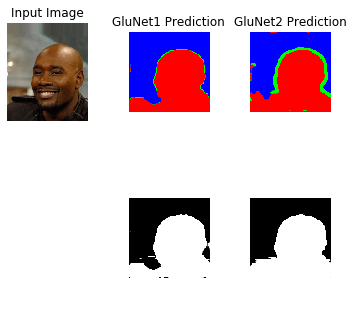

In [15]:
compare_models(GNet1,GNet2)

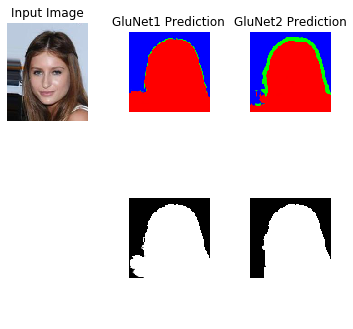

In [31]:
compare_models(GNet1,GNet2)

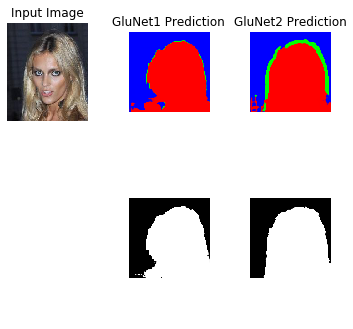

In [30]:
compare_models(GNet1,GNet2)